#Engenharia e Análise de Dados
###Trabalho Final - Dataset Homer and Bart Classification
###RNA e Deep Learning
####Profº Vitor Casadei
Alunos: Ana Raissa do Nascimento Silva (arns@cesar.school)

In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

import os

import cv2
import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

In [2]:
import kagglehub

In [5]:
path = kagglehub.dataset_download("juniorbueno/neural-networks-homer-and-bart-classification")

print("Path to dataset files:", path)

100%|██████████| 8.06M/8.06M [00:00<00:00, 66.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1


In [6]:
print(os.listdir(path))

['homer_bart_1']


In [16]:
files = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
print("Total files found:", len(files))
print(files)

Total files found: 269
['/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/bart117.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/bart120.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/homer7.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/homer47.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/bart155.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/homer17.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart-classification/versions/1/homer_bart_1/bart32.bmp', '/root/.cache/kagglehub/datasets/juniorbueno/neural-networks-homer-and-bart

In [8]:
img_height, img_width = 64, 64

In [87]:
def load_and_preprocess_data(path, img_height, img_width):
    images = []
    labels = []

    for file_path in glob.glob(os.path.join(path, '**', '*.*'), recursive=True):
        if file_path.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
            img = cv2.imread(file_path)


            if img is None:
                continue
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (img_width, img_height))
            images.append(img.astype('float32') / 255.0)


            filename = os.path.basename(file_path).lower()

            if 'homer' in filename:
              labels.append(0)
            elif 'bart' in filename:
              labels.append(1)
            else:
              print("Arquivo desconhecido:", filename)

    images = np.array(images)


    images = np.transpose(images, (0, 3, 1, 2))

    labels = np.array(labels)

    return images, labels

In [38]:
images, labels = load_and_preprocess_data(path, img_height, img_width)

In [39]:
print("Imagens:", images.shape)
print("Labels:", labels.shape)

Imagens: (269, 3, 64, 64)
Labels: (269,)


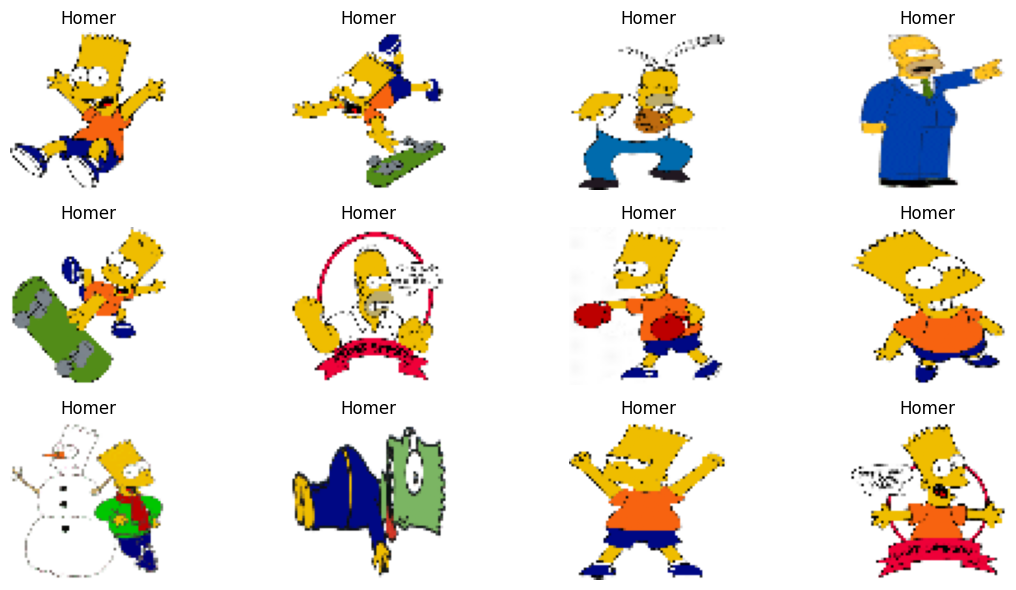

In [25]:
def show_sample_grid(images, labels, n=12):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(3, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        lbl = labels[i].item()
        plt.title("Homer" if lbl == 0 else "Bart")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_grid(images, labels, n=12)

In [42]:
images, labels = load_and_preprocess_data(path, img_height, img_width)
print(dict(zip(*np.unique(labels, return_counts=True))))

{np.int64(0): np.int64(109), np.int64(1): np.int64(160)}


In [76]:
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(images, labels)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

/tmp/ipython-input-3895247134.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)
/tmp/ipython-input-3895247134.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [77]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()

        self.fc1 = nn.Linear(3 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLPClassifier()
print(model)

MLPClassifier(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [79]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # ----- TREINAMENTO -----
    for imgs, lbls in train_loader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # ----- VALIDAÇÃO -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()

    val_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

Epoch [1/10] | Train Loss: 2.0034 | Val Loss: 0.6650 | Val Acc: 62.50%
Epoch [2/10] | Train Loss: 0.7437 | Val Loss: 0.7895 | Val Acc: 62.50%
Epoch [3/10] | Train Loss: 0.7064 | Val Loss: 0.6133 | Val Acc: 70.00%
Epoch [4/10] | Train Loss: 0.5383 | Val Loss: 0.5470 | Val Acc: 67.50%
Epoch [5/10] | Train Loss: 0.4578 | Val Loss: 0.7385 | Val Acc: 70.00%
Epoch [6/10] | Train Loss: 0.4385 | Val Loss: 0.8857 | Val Acc: 65.00%
Epoch [7/10] | Train Loss: 0.4350 | Val Loss: 0.5887 | Val Acc: 72.50%
Epoch [8/10] | Train Loss: 0.3478 | Val Loss: 0.6133 | Val Acc: 77.50%
Epoch [9/10] | Train Loss: 0.3606 | Val Loss: 1.1845 | Val Acc: 57.50%
Epoch [10/10] | Train Loss: 0.3469 | Val Loss: 0.6855 | Val Acc: 70.00%


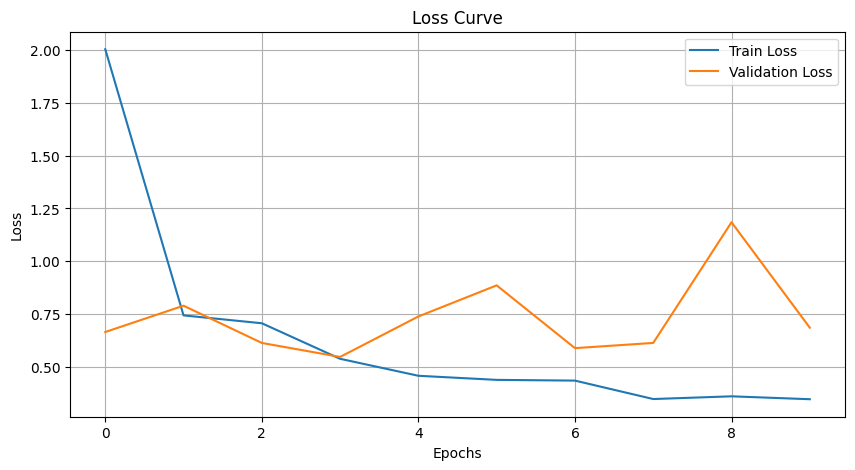

In [80]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

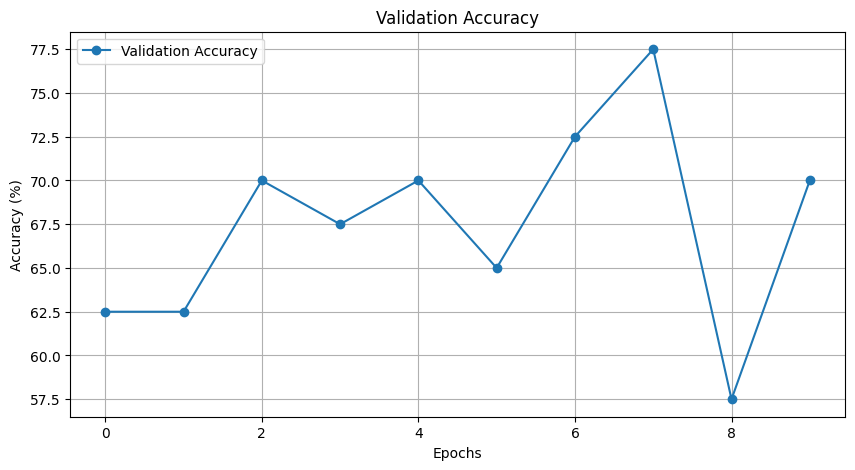

In [81]:
plt.figure(figsize=(10,5))
plt.plot(val_accuracies, marker='o', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

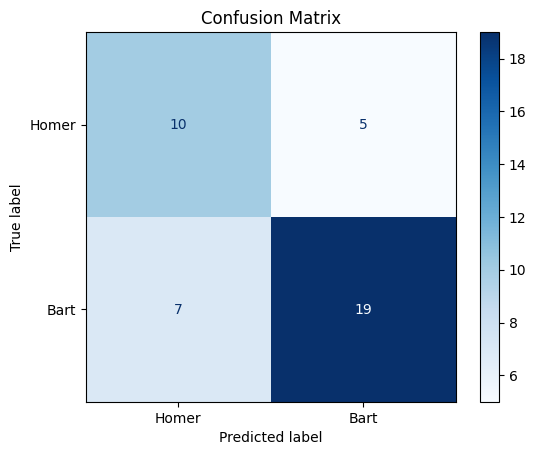

In [82]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Homer", "Bart"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [83]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, lbls in test_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()

test_acc = 100 * correct / total
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 70.73%


In [84]:
print(classification_report(all_labels, all_preds, target_names=["Homer", "Bart"]))

              precision    recall  f1-score   support

       Homer       0.59      0.67      0.62        15
        Bart       0.79      0.73      0.76        26

    accuracy                           0.71        41
   macro avg       0.69      0.70      0.69        41
weighted avg       0.72      0.71      0.71        41



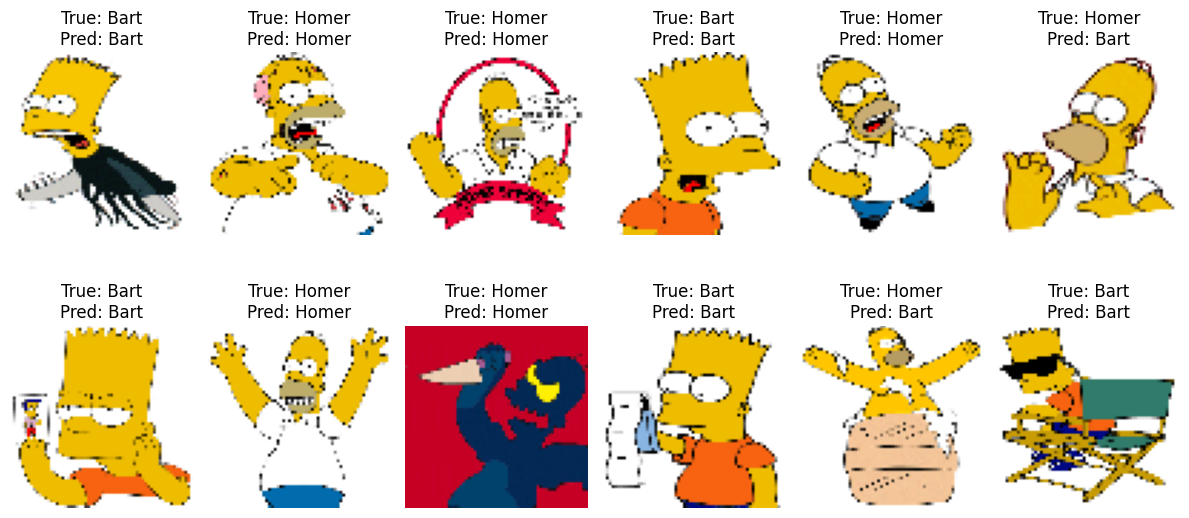

In [90]:
model.eval()
indices = random.sample(range(len(test_ds)), 12)
plt.figure(figsize=(12,6))

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0))
        _, pred = torch.max(output, 1)

    pred_label = "Homer" if pred.item() == 0 else "Bart"
    true_label = "Homer" if label.item() == 0 else "Bart"

    img_show = img.permute(1,2,0).numpy()

    plt.subplot(2, 6, i+1)
    plt.imshow(img_show)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Logo no início, enfrentei um problema na etapa de pré-processamento das imagens. A forma usada para identificar as classes estava levando em consideração todo o caminho do arquivo, e como o diretório continha o nome homer_bart_1, todas as imagens acabaram sendo rotuladas com a classe “Homer”.
Esse erro só foi detectado ao observar que na etapa de treinamento o loss se mantinha em zero e a acurácia atingia 100, indicando claramente uma inconsistência nos dados.

Após corrigir as classes para considerar apenas o nome do arquivo, realizei uma divisão adequada dos dados em train, validation e test (70%, 15%, 15%), garantindo uma avaliação metodologicamente correta.

Com essa estrutura, usei o modelo MLP para treinar os dados. As curvas de loss mostram que o modelo aprendeu durante o treinamento, mas apresentou oscilação na validação, o que sugere underfitting ou alguma espécie de generalização.

Ao final, o modelo atingiu 70,73% de acurácia no conjunto de teste.